In [1]:
%%time
import sys;
import datetime
print(datetime.datetime.now())
print('---------------------------------------')
!{sys.executable} -m pip install -r requirements.txt


2020-11-19 20:11:12.559469
---------------------------------------
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
CPU times: user 55.5 ms, sys: 17.5 ms, total: 72.9 ms
Wall time: 2.34 s


In [2]:
%%time
import boto3
import sagemaker

session = sagemaker.Session() 
region = session.boto_region_name 

bucket = 'sagemaker-jfox'
 
prefix = 'sagemaker/xgboost'
role = sagemaker.get_execution_role()
print('Role', role)
print(f'Bucket {bucket} in region {region}')

Role arn:aws:iam::649592902942:role/service-role/AmazonSageMaker-ExecutionRole-20201021T144991
Bucket sagemaker-jfox in region eu-west-1
CPU times: user 784 ms, sys: 79.4 ms, total: 863 ms
Wall time: 2.92 s


In [3]:
%%time
import random
import pandas as pd
raw_data_filename = 'frauddetection.csv'

s3 = boto3.resource('s3', region_name=region)
#s3.Bucket(bucket).download_file('frauddetection/'+raw_data_filename, raw_data_filename)
percent_to_read=100
fraction_to_read=percent_to_read/100 # Divide by 1000 and not 100 as expected?
df = pd.read_csv('./'+raw_data_filename,  skiprows=lambda i: i>0 and random.random() > fraction_to_read)
pd.set_option('display.max_rows', 10) 
pd.set_option('display.width', 1000)

print('Length', len(df))
target_col='isFraud'
df

Length 6362620
CPU times: user 11.1 s, sys: 1.21 s, total: 12.3 s
Wall time: 13.3 s


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


All `isFraud` rows have `type` `TRANSFER` or `CASH_OUT`, never  `CASH_IN` or `PAYMENT`. Could filter these out.

Counts of each class to determine imbalance.

In [4]:
def count_positive_and_negative(df):
    num_positive = len(df.loc[  df[target_col] == 1 ])
    num_negative = len(df) - num_positive
    return num_positive, num_negative

num_positive, num_negative = count_positive_and_negative(df)

print('Fraud', num_positive, '; Not fraud', num_negative, '; Total', len(df))

Fraud 8213 ; Not fraud 6354407 ; Total 6362620


`isFlaggedFraud` does not add anything, so drop it 

In [5]:
df = df.drop(['isFlaggedFraud'], axis=1)


array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

Plot distribution of positive vs negative, in log scale because of the imbalance

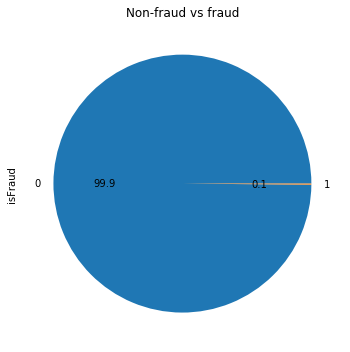

In [6]:
import math
import matplotlib.pyplot as plt   
def plot_positive_negative_counts(df, target_col):
        df[target_col].value_counts().plot.pie(figsize=(5, 5), autopct='%.1f')
        plt.title('Non-fraud vs fraud')
        plt.tight_layout()
    
plot_positive_negative_counts(df,target_col)

Scale the numerical values.

In [7]:
#Split numerical from non-numerical
columns = df.columns
numerical_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
other_col =[c for c in columns if  c not in numerical_cols]
df_other = df[other_col]

df_num = df[numerical_cols]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_num = pd.DataFrame(scaler.fit_transform(df_num), columns=df_num.columns)
df = pd.concat([df_num, df_other], axis=1)
df = df[columns] # Put back in old order
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,-0.281560,C1231006815,-0.229810,-0.237622,M1979787155,-0.323814,-0.333411,0
1,1,PAYMENT,-0.294767,C1666544295,-0.281359,-0.285812,M2044282225,-0.323814,-0.333411,0
2,1,TRANSFER,-0.297555,C1305486145,-0.288654,-0.292442,C553264065,-0.323814,-0.333411,1
3,1,CASH_OUT,-0.297555,C840083671,-0.288654,-0.292442,C38997010,-0.317582,-0.333411,1
4,1,PAYMENT,-0.278532,C2048537720,-0.274329,-0.282221,M1230701703,-0.323814,-0.333411,0
...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,0.264665,C786484425,-0.171108,-0.292442,C776919290,-0.323814,-0.240959,1
6362616,743,TRANSFER,10.153953,C1529008245,1.896491,-0.292442,C1881841831,-0.323814,-0.333411,1
6362617,743,CASH_OUT,10.153953,C1162922333,1.896491,-0.292442,C1365125890,-0.303665,1.403027,1
6362618,743,TRANSFER,1.109765,C1685995037,0.005581,-0.292442,C2080388513,-0.323814,-0.333411,1


Move target to the left, per Sagemaker standard

In [8]:
cols = df.columns.tolist()
cols.remove(target_col)
cols = [target_col] + cols
df = df[cols] 

Transform hour of day to a form suited for cyclical data

In [13]:
import numpy as np

df['hour24sin'] = np.sin(df['step'] * math.pi/24)
df['hour24cos'] = np.cos(df['step'] * math.pi/24)
df = df.drop('step', axis=1)
df

,isFraud,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,hour24sin,hour24cos
0,0,PAYMENT,-0.281560,C1231006815,-0.229810,-0.237622,M1979787155,-0.323814,-0.333411,0.130526,0.991445
1,0,PAYMENT,-0.294767,C1666544295,-0.281359,-0.285812,M2044282225,-0.323814,-0.333411,0.130526,0.991445
2,1,TRANSFER,-0.297555,C1305486145,-0.288654,-0.292442,C553264065,-0.323814,-0.333411,0.130526,0.991445
3,1,CASH_OUT,-0.297555,C840083671,-0.288654,-0.292442,C38997010,-0.317582,-0.333411,0.130526,0.991445
4,0,PAYMENT,-0.278532,C2048537720,-0.274329,-0.282221,M1230701703,-0.323814,-0.333411,0.130526,0.991445
...,...,...,...,...,...,...,...,...,...,...,...
6362615,1,CASH_OUT,0.264665,C786484425,-0.171108,-0.292442,C776919290,-0.323814,-0.240959,0.130526,-0.991445
6362616,1,TRANSFER,10.153953,C1529008245,1.896491,-0.292442,C1881841831,-0.323814,-0.333411,0.130526,-0.991445
6362617,1,CASH_OUT,10.153953,C1162922333,1.896491,-0.292442,C1365125890,-0.303665,1.403027,0.130526,-0.991445
6362618,1,TRANSFER,1.109765,C1685995037,0.005581,-0.292442,C2080388513,-0.323814,-0.333411,0.130526,-0.991445


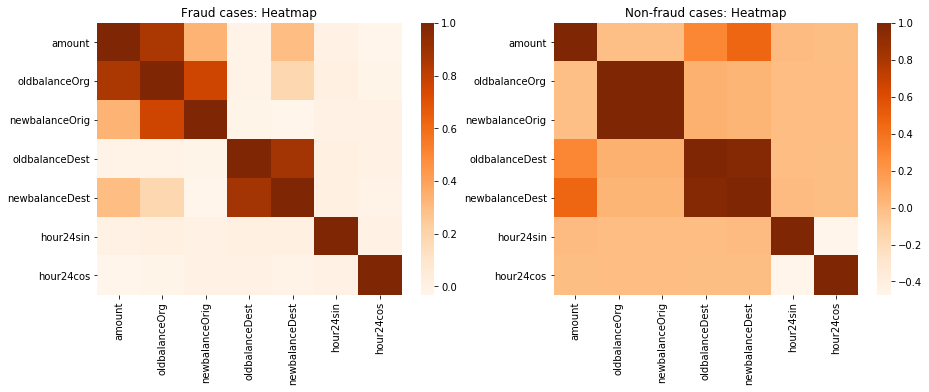

In [26]:
import seaborn  

fig, axes = plt.subplots( 1,2, figsize=(15,5))

def heatmap(fraud_cases):
    lbl='Fraud' if  fraud_cases else 'Non-fraud'
    # Coerced to int, below
    axes[1-fraud_cases].set_title(f'{lbl} cases: Heatmap')
    seaborn.heatmap(df.query(f'isFraud == {fraud_cases}').drop([target_col], 1).corr(),  cmap='Oranges', ax=axes[1-fraud_cases])

heatmap(True)
heatmap(False)

plt.show()

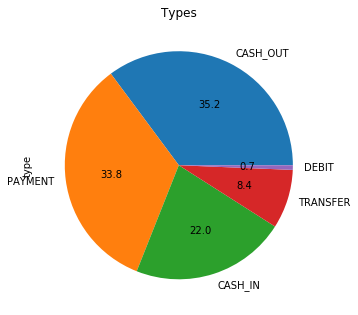

In [22]:
df['type'].value_counts().plot.pie(figsize=(5, 5), autopct='%.1f')
plt.title('Types')
plt.tight_layout()

Make dummies (onehot) for `type` field.

In [ ]:
df_dummies=pd.get_dummies(df['type'],drop_first=True )

df=df.drop(['type'], axis=1)
df = pd.concat([df, df_dummies], axis=1)
 

We could use *HashingEncoder* to handle categorical columns with high cardinality. These cannot be onehotted as that would generate too many columns and a too-sparse matrix. However, this seems to provide no accuracy benefit.

In [ ]:
%%time
high_cardinality__categorical_col = ['nameOrig', 'nameDest']
use_hashing_encoder = False
if not use_hashing_encoder:
    print('Dropping high-cardinality categorical columns')
    df=df.drop(high_cardinality__categorical_col, axis=1)
else:
   import category_encoders as ce  
   columns_before = [x for x in df.columns if x not in high_cardinality__categorical_col+[target_col]]
   col_prefix = 'col_'
  
   def make_col_mapping(cols):
      col_mapping = {}
      for c in cols:
          if c[:4] == col_prefix:
             num = c.split('_')[-1]
             int(num) # check format
             col_mapping[c] = hashencode_this + "_" + num
     
      return col_mapping

  
   def hashencode(hashencode_this, df, previous_hash_cols):
        """Could hashencode both columns, but for now hashencode does not seem to provide a benefit."""
        for c in df.columns:
            assert c[:4] != col_prefix,  df.columns
        cpus_in_t2xlarge = 4
        default_max_sample = len(df)/cpus_in_t2xlarge
        max_sample = default_max_sample/2
        ce_hash = ce.HashingEncoder(cols = [hashencode_this],max_sample=max_sample)
        X1 = df.drop([target_col], axis=1)
        y1 = df[target_col]
        with_hashing = ce_hash.fit_transform(X1, y1)
        hashed = with_hashing.drop(columns_before+previous_hash_cols, axis=1)
        generated_cols = [x for x in hashed.columns if x[:4] == col_prefix]
        col_mapping = make_col_mapping(generated_cols)

        hashed = hashed.rename(columns = col_mapping)
        df = pd.concat([y1, X1, hashed], axis=1)

        df = df.drop([hashencode_this], axis=1)
        return df, list(col_mapping.values())

   print('Hashencoding high-cardinality categorical columns')
   previous_hash_cols = []
   for hashencode_this in high_cardinality__categorical_col: 
     df, previous_hash_cols = hashencode(hashencode_this,df,previous_hash_cols)
 

Optionally use *SMOTENC* for unbalanced classes, though we may stick with the XGBoost parameters.

In [ ]:
%%time 

from imblearn.over_sampling import SMOTENC

use_smote = False # Can just use weighting in XGBOOST instead of SMOTENC

if use_smote:
   ycol=target_col
   Xcol=list(df.columns)
   Xcol.remove(ycol)
 
   categorical_columns=[i for i in range(len(Xcol)) 
                     if Xcol[i] not in ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]

   smotenc = SMOTENC(categorical_columns,random_state = 101)

   X, y = smotenc.fit_resample(df[Xcol], df[ycol])
   y_df = pd.DataFrame({target_col: y} )

   df = pd.concat([X, y_df], axis=1)

In [ ]:
plot_positive_negative_counts(df,target_col)

# Split  with randomization

In [ ]:
import numpy as np
len_ = len(df)
train_data, validation_data, test_data = np.split(df.sample(frac=1, random_state=1729), [int(0.7 * len_), int(0.9 * len_)])

Using libSVM for performance.

In [ ]:
%%time
from sklearn.datasets import dump_svmlight_file   

lengths = [] 

for d in [(train_data, 'train.libsvm'), ( validation_data, 'validation.libsvm'), (test_data, 'test.libsvm')]:
   dataset=d[0]
   file_ = d[1]
   lengths.append((d[1].split('.')[0],len(dataset)))
   dump_svmlight_file(X=dataset.drop([target_col], axis=1), y=dataset[target_col], f=d[1])

print('Length of datasets:', lengths )

s3 = boto3.resource('s3', region_name=region) 

for filename in ['train.libsvm', 'validation.libsvm']:
   s3.Bucket(bucket).Object(prefix + '/'+filename.split('.')[0]+'/'+filename).upload_file(filename)

In [ ]:
def s3_path(subset):
  return sagemaker.s3_input(s3_data='s3://{}/{}/{}'.format(bucket, prefix,subset), content_type='libsvm')

s3_input_train = s3_path('train')
s3_input_validation =s3_path('validation')

---
## Train

To train, first set up the parameters for an Amazon SageMaker Estimator object, and the hyperparameters for the algorithm itself.

In [ ]:
from sagemaker.amazon.amazon_estimator import get_image_uri

import math

container = get_image_uri(region, 'xgboost','1.0-1')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    base_job_name='fraud-detection-job',
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=session)
num_positive, num_negative=count_positive_and_negative(train_data)
scale_pos_weight=math.sqrt(num_negative / num_positive )
print(f'num_positive: {num_positive}, num_negative: {num_negative}, scale_pos_weight {scale_pos_weight:.1f}')

xgb.set_hyperparameters(max_depth=3,
                        eta=0.1,
                        gamma=4,
                        subsample=0.5,
                        eval_metric='error@.35',     
                        objective='binary:logistic',
                        scale_pos_weight=scale_pos_weight,
                        num_round=100, 
                        silent=0)

Run the `fit` training  or hypertuned-training job.

In [ ]:
%%time
hypertune = True
import pprint

if not hypertune:
    result = xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})
    training_job_name = xgb._current_job_name
else:
    import time

    from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
    hyperparameter_ranges = {'eta': ContinuousParameter(0, 1),
                            'min_child_weight': ContinuousParameter(1, 10),
                            'alpha': ContinuousParameter(0, 2),
                            'max_depth': IntegerParameter(1, 10)}


    objective_metric_name = 'validation:f1'

    tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10, 
                            base_tuning_job_name='hypertune',
                            max_parallel_jobs=10)
    
    print('Starting hypertuning job')
    tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}, include_cls_metadata=False, wait=False)
    print('Started hypertuning job', tuner.latest_tuning_job.job_name)

    counter = 0
    status = 'InProgress'
    while status == 'InProgress':
        tuning_job_result=boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
           HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)
        counter += 0.5
        time.sleep(30)   
        status = tuning_job_result['HyperParameterTuningJobStatus']
        print(f'{counter} min., {status};', end=' ')
        
    if 'BestTrainingJob' in tuning_job_result:
       training_job_name = tuning_job_result['BestTrainingJob']['TrainingJobName']
    else:
       pprint.pprint(tuning_job_result)
       raise Exception('No best job identified')


---
## Host

Deploy the trained model to an endpoint.

In [ ]:
import datetime 
import time

endpoint_name = 'fraud-detect-endpoint'
model_name = training_job_name + '-mod'

info = session.describe_training_job(training_job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
  'Image': container,
  'ModelDataUrl': model_data
}

create_model_response = session.create_model(
      name = model_name,
      role = role,
      container_defs = primary_container)


date_ = datetime.datetime.now().strftime('%m%d-%H%M%S')

endpoint_config_name = session.create_endpoint_config(name=endpoint_name + 'config' + date_,
                                              model_name=model_name,
                                              initial_instance_count=1,
                                              instance_type='ml.m5.xlarge',
                                              accelerator_type='ml.eia2.medium')

client = boto3.client('sagemaker')
counter = 0
try_now = True
while try_now:
  counter += 0.5
  try:
     updated_endpoint = client.update_endpoint(EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name)
     try_now = False
  except Exception as e:
     if 'Could not find endpoint'  in str(e):
        print('Could not find endpoint; Trying to create')
        updated_endpoint=client.create_endpoint(EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name)
        try_now = False
     elif 'Cannot update in-progress endpoint' in str(e):
        print(f'{counter} min: Cannot update in-progress endpoint; retrying', end='. ')
        time.sleep(30)
        try_now = True
     else:  
        raise e

endpt_status = 'Updating'
counter = 0 
while endpt_status in ['Updating', 'Creating']:
    counter += 0.5
    endpt_status = client.describe_endpoint(EndpointName=endpoint_name)['EndpointStatus']
    print(f'{counter} min: {endpt_status}; ',end='')
    time.sleep(30)

print('Finished creating or updating endpoint')

xgb_predictor = sagemaker.predictor.RealTimePredictor(endpoint=endpoint_name, sagemaker_session=sagemaker.Session())

---

## Evaluation

Now that we have our hosted endpoint, we can generate predictions from  the  test data set.

Compared actual to predicted values of whether the transaction was a "fraud" (`1`) or not (`0`).  Then we'll produce a  confusion matrix.

In [ ]:
xgb_predictor.content_type = 'text/x-libsvm'
xgb_predictor.deserializer = None

def do_predict(data):
    payload = '\n'.join(data)
    response = xgb_predictor.predict(payload).decode('utf-8')
    result = response.split(',')
    preds = [float(num) for num in result]
    preds = [round(num) for num in preds]
    return preds

def batch_predict(data, batch_size):
    items = len(data)
    arrs = []
    
    for offset in range(0, items, batch_size):
        if offset+batch_size < items:
            results = do_predict(data[offset:(offset+batch_size)])
            arrs.extend(results)
        else:
            arrs.extend(do_predict(data[offset:items]))
        sys.stdout.write('.')
    return(arrs)

In [ ]:
%%time
import json

with open('test.libsvm', 'r') as f:
    payload = f.read().strip()

labels = [int(line.split(' ')[0]) for line in payload.split('\n')]
test_data = [line for line in payload.split('\n')]
preds = batch_predict(test_data, 100)

In [ ]:
actual_pos = sum(1 for i in range(len(labels)) if 1 == labels[i])
actual_neg = sum(1 for i in range(len(labels)) if 0 == labels[i])

pred_pos = sum(1 for i in range(len(preds)) if 1 == preds[i])
pred_neg = sum(1 for i in range(len(preds)) if 0 == preds[i])

true_pos = sum(1 for i in range(len(preds)) if preds[i] == 1 == labels[i])
true_neg = sum(1 for i in range(len(preds)) if preds[i] == 0 == labels[i])

false_pos=sum(1 for i in range(len(preds)) if preds[i] == 1 and 0 == labels[i])
false_neg=sum(1 for i in range(len(preds)) if preds[i] == 0 and 1 == labels[i])

recall = true_pos / (true_pos + false_neg)
precision = true_pos / (true_pos + false_pos)
f1 = (2 * precision * recall) / (precision + recall)
error = sum(1 for i in range(len(preds)) if preds[i] != labels[i]) / float(len(preds))

assert recall <= f1 <= precision or precision <= f1 <= recall 
assert true_pos + false_neg == actual_pos
assert true_neg + false_pos == actual_neg
#print('pred_pos', pred_pos,'pred_neg', pred_neg)

assert len(preds)==len(labels)

#print(len(preds), 'predictions and labels')

#print('actual_pos', actual_pos, 'actual_neg', actual_neg)
assert actual_pos+actual_neg==len(labels)
                   
#print('true_pos', true_pos, 'false_pos', false_pos)
#assert  true_pos+false_pos == pred_pos

#print('true_neg', true_neg, 'false_neg', false_neg )
assert true_neg+false_neg== pred_neg

#print('pred_pos+pred_neg',pred_pos+pred_neg)
assert pred_pos+pred_neg==len(preds)

print(f'Recall = {recall:.2f}')
print(f'Precision = {precision:.2f}')
print(f'Error rate = {error:.2f}')
print(f'F1 = {f1:.2f}')

Show confusion matrix.

In [ ]:
 
pd.crosstab(index=np.array(labels), columns=np.array(preds), rownames=['actual fraud'],  colnames=['predicted as fraud'])

Clean up to save money

In [ ]:
#session.delete_endpoint(xgb_predictor.endpoint)